## Realized Volatility analysis 

### Step 1: Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

### Step 2: Data Preparation

In [2]:
# Step 1: Retrieve Data
ticker = "^GSPC"  # S&P 500 Index
start_date = "2020-01-01"
end_date = "2023-01-01"
data = yf.download(ticker, start=start_date, end=end_date)

# Calculate daily returns
data['Returns'] = data['Adj Close'].pct_change()

# Drop missing values
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


### Step 3: Calculate Volatility Measures

In [3]:
#Calculate Volatility Measures

# Close-Close Volatility (Standard Deviation of Returns)
def calc_close_close_vol(data, window):
    return data['Returns'].rolling(window=window).std() * np.sqrt(252)

# Parkinson Volatility
def calc_parkinson_vol(data, window):
    return (1 / (4 * np.log(2)) * (np.log(data['High'] / data['Low']) ** 2)).rolling(window=window).sum() * np.sqrt(252 / window)

# Garman-Klass Volatility
def calc_garman_klass_vol(data, window):
    log_hl = np.log(data['High'] / data['Low'])
    log_co = np.log(data['Close'] / data['Open'])
    return np.sqrt((0.5 * log_hl ** 2) - ((2 * np.log(2) - 1) * log_co ** 2)).rolling(window=window).sum() * np.sqrt(252 / window)

# GKYZ Volatility (Yang-Zhang)
def calc_gkyz_vol(data, window):
    log_hl = np.log(data['High'] / data['Low'])
    log_oc = np.log(data['Open'] / data['Close'].shift(1))
    log_cc = np.log(data['Close'] / data['Close'].shift(1))
    sigma_oc = log_oc.rolling(window=window).std()
    sigma_cc = log_cc.rolling(window=window).std()
    return np.sqrt((0.34 * log_hl ** 2) + (0.66 * sigma_oc ** 2) + sigma_cc ** 2).rolling(window=window).sum() * np.sqrt(252 / window)

In [4]:
# Window for rolling calculation
window = 21  # 1-month equivalent (assuming 21 trading days in a month)

# Calculate volatilities
data['Close-Close Vol'] = calc_close_close_vol(data, window)
data['Parkinson Vol'] = calc_parkinson_vol(data, window)
data['Garman-Klass Vol'] = calc_garman_klass_vol(data, window)
data['GKYZ Vol'] = calc_gkyz_vol(data, window)

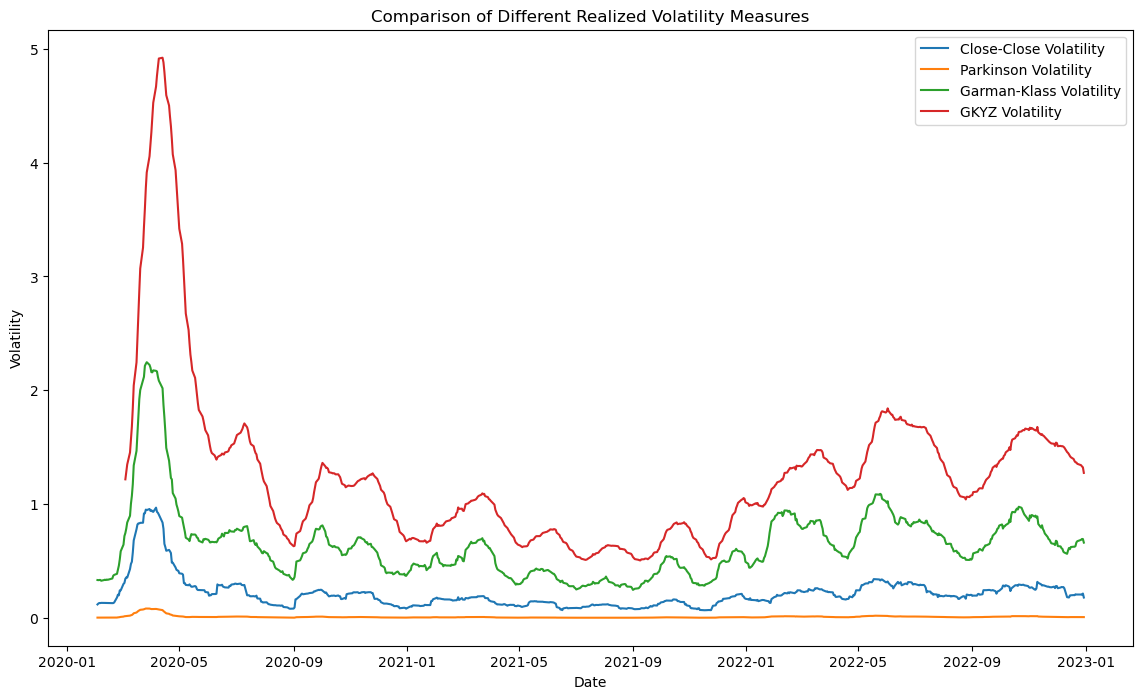

In [5]:
# Step 3: Visualization
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Close-Close Vol'], label='Close-Close Volatility')
plt.plot(data.index, data['Parkinson Vol'], label='Parkinson Volatility')
plt.plot(data.index, data['Garman-Klass Vol'], label='Garman-Klass Volatility')
plt.plot(data.index, data['GKYZ Vol'], label='GKYZ Volatility')
plt.title('Comparison of Different Realized Volatility Measures')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [6]:
# Step 4: Auto-regression and Predictive Power (using close-close vol as an example)
from statsmodels.tsa.ar_model import AutoReg

# Let's do a simple 1-day lag auto-regression for illustration
model = AutoReg(data['Close-Close Vol'].dropna(), lags=1)
model_fitted = model.fit()

# Print the summary of the model
print(model_fitted.summary())

                            AutoReg Model Results                             
Dep. Variable:        Close-Close Vol   No. Observations:                  735
Model:                     AutoReg(1)   Log Likelihood                1991.022
Method:               Conditional MLE   S.D. of innovations              0.016
Date:                Sun, 01 Sep 2024   AIC                          -3976.043
Time:                        15:20:19   BIC                          -3962.248
Sample:                             1   HQIC                         -3970.722
                                  735                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0014      0.001      1.369      0.171      -0.001       0.004
Close-Close Vol.L1     0.9936      0.004    244.050      0.000       0.986       1.002
                    

C:\Users\tribh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


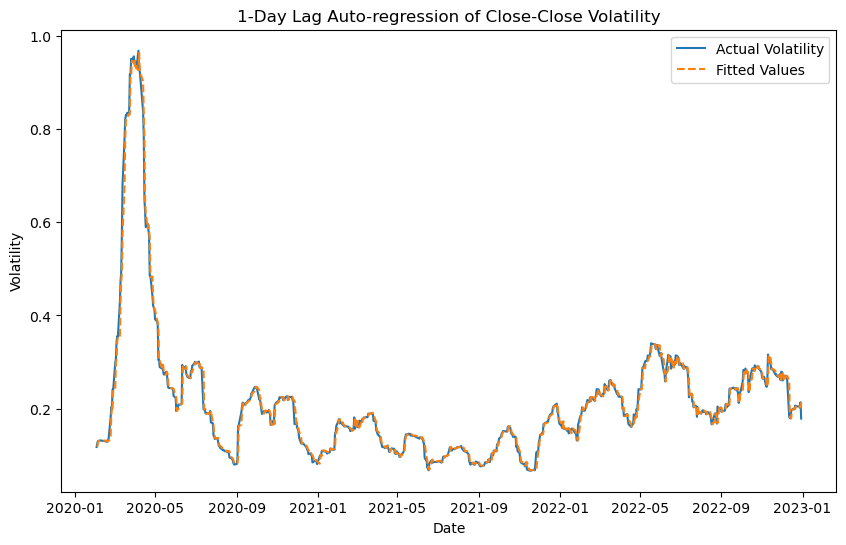

In [7]:
# Plot the auto-regression result
plt.figure(figsize=(10, 6))
plt.plot(data['Close-Close Vol'].dropna(), label='Actual Volatility')
plt.plot(model_fitted.fittedvalues, label='Fitted Values', linestyle='--')
plt.title('1-Day Lag Auto-regression of Close-Close Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()